## COMPAS Analysis using Aequitas
<a id='top_cell'></a>
Recent work in the Machine Learning community has raised concerns about the risk of unintended bias in Algorithmic Decision-Making systems, affecting individuals unfairly. While many bias metrics and fairness definitions have been proposed in recent years, the community has not reached a consensus on which definitions and metrics should be used, and there has been very little empirical analyses of real-world problems using the proposed metrics.

We present the Aequitas toolkit as an intuitive addition to the machine learning workflow, enabling users to to seamlessly test models for several bias and fairness metrics in relation to multiple population groups. We believe the tool will faciliate informed and equitable decision-making around developing and deploying predictive risk-assessment tools for both machine learnining practitioners and policymakers, allowing researchers and program managers to answer a host of questions related to machine learning models, including:

- [What biases exist in my model?](#existing_biases)
    - [What is the distribution of groups, predicted scores, and labels across my dataset?](#xtab)
    - [What are bias metrics across groups?](#xtab_metrics)
    - [How do I interpret biases in my model?](#interpret_bias)
    - [How do I visualize biases in my model?](#bias_viz)

- [What levels of disparity exist between population groups?](#disparities)
    - [How does the selected reference group affect disparity calculations?](#disparity_calc)
    - [How do I interpret calculated disparity ratios?](#interpret_disp)
    - [How do I visualize disparities in my model?](#disparity_viz)

- [How do I assess model fairness??](#fairness)
    - [How do I interpret parities?](#interpret_fairness)
    - [How do I visualize bias metric parity?](#fairness_group_viz)
    - [How do I visualize parity between groups in my model?](#fairness_disp_viz)


We apply the toolkit to the COMPAS dataset reported on by ProPublica below.

### Background

In 2016, ProPublica reported on racial inequality in automated criminal risk assessment algorithms. The [report](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) is based on [this analysis](https://github.com/propublica/compas-analysis). Using a clean version of the COMPAS dataset from the ProPublica GitHub repo, we demostrate the use of the Aequitas bias reporting tool.

Northpointe's COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) is one of the most widesly utilized risk assessment tools/ algorithms within the criminal justice system for guiding decisions such as how to set bail. The ProPublica dataset represents two years of COMPAS predicitons from Broward County, FL.

In [1]:
!pip install "aequitas==1.0.0" &> /dev/null

import pandas as pd
import seaborn as sns
from aequitas.audit import Audit
from aequitas.fairness import Fairness
import aequitas.plot as ap
import numpy as np

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from helpers.mlp_prediction import *

# import warnings; warnings.simplefilter('ignore')

%matplotlib inline

In [2]:
path = "/Users/nilsness/Desktop/Uni Skripte und Folien/Masterarbeit/Programming/Loan-Approval-Prediction.csv"
datasetX, dataset ,target, numerical, categorical = load_and_preprocess_data('/Users/nilsness/Desktop/Uni Skripte und Folien/Masterarbeit/Programming/Loan-Approval-Prediction.csv')
dataset

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [3]:
import pandas as pd

# Calculate the number of instances to remove
num_instances = int(0.75 * len(dataset[(dataset['Gender'] == 'Female') & (dataset['Loan_Status'] == 'Y')]))

# Get the indices of the instances to remove
indices_to_remove = dataset[(dataset['Gender'] == 'Female') & (dataset['Loan_Status'] == 'Y')].sample(num_instances).index

# Remove the instances from the dataset
dataset = dataset.drop(indices_to_remove)


In [4]:
target = dataset['Loan_Status']
datasetX = dataset.drop(columns=['Loan_Status'])
dataset


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
608,Male,Yes,0,Graduate,No,3232,1950.0,108.0,360.0,1.0,Rural,Y
610,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [5]:
x_train_encoded, x_test_encoded, y_train, y_test, Z_train, Z_test, datasetX1, target,Z, dataset_num_headers, scaler, encoder = do_it_like_numbers_do(datasetX,target,numerical,categorical)


In [6]:
models, model_list, transformations = build_pipeline(numerical,categorical)

In [26]:
model_list[0].fit(x_train_encoded, y_train)
prediction = model_list[0].predict(dataset_num_headers)
dataset['Predictions'] = prediction
dataset_num_headers['Predictions'] = prediction
cat = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area','Credit_History']
dataset_num_headers[cat]=dataset_num_headers[cat].astype('category')
dataset_num_headers



,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area_Rural,Property_Area,Property_Area_Urban,Predictions
1,1,1,1,0,0,0.054830,0.044567,0.201354,0.729730,1,1,0,0,0
2,1,1,0,0,1,0.035250,0.000000,0.096447,0.729730,1,0,0,1,1
3,1,1,0,1,0,0.030093,0.069687,0.187817,0.729730,1,0,0,1,1
4,1,0,0,0,0,0.072356,0.000000,0.223350,0.729730,1,0,0,1,1
5,1,1,2,0,1,0.065145,0.124006,0.436548,0.729730,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,1,1,0,0,0,0.038120,0.057629,0.167513,0.729730,1,1,0,0,1
610,1,1,3,0,0,0.048930,0.000000,0.052453,0.324324,1,1,0,0,1
611,1,1,1,0,0,0.097984,0.007093,0.412860,0.729730,1,0,0,1,1
612,1,1,2,0,0,0.091936,0.000000,0.301184,0.729730,1,0,0,1,1


## Pre-Aequitas: Exploring the Loan Application

__Risk assessment by Gender__



In [35]:
aq_palette = sns.diverging_palette(220, 20, as_cmap=True)
df=dataset_num_headers

In [36]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area_Rural,Property_Area,Property_Area_Urban,Predictions
1,1,1,1,0,0,0.054830,0.044567,0.201354,0.72973,1,1,0,0,0
2,1,1,0,0,1,0.035250,0.000000,0.096447,0.72973,1,0,0,1,1
3,1,1,0,1,0,0.030093,0.069687,0.187817,0.72973,1,0,0,1,1
4,1,0,0,0,0,0.072356,0.000000,0.223350,0.72973,1,0,0,1,1
5,1,1,2,0,1,0.065145,0.124006,0.436548,0.72973,1,0,0,1,1


In [37]:
dataset_num_headers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440 entries, 1 to 613
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Gender               440 non-null    category
 1   Married              440 non-null    category
 2   Dependents           440 non-null    category
 3   Education            440 non-null    category
 4   Self_Employed        440 non-null    category
 5   ApplicantIncome      440 non-null    float32 
 6   CoapplicantIncome    440 non-null    float32 
 7   LoanAmount           440 non-null    float32 
 8   Loan_Amount_Term     440 non-null    float32 
 9   Credit_History       440 non-null    category
 10  Property_Area_Rural  440 non-null    int64   
 11  Property_Area        440 non-null    category
 12  Property_Area_Urban  440 non-null    int64   
 13  Predictions          440 non-null    int64   
dtypes: category(7), float32(4), int64(3)
memory usage: 24.6 KB


In [38]:
loan_status_percentage = df.groupby('Loan_Status')
loan_status_percentage.head()


KeyError: 'Loan_Status'

In [39]:
# Annahme: Ihr DataFrame heißt "df" und die Spalte mit der Kreditgenehmigungsrate heißt "Loan_Status"

# Durchschnittliche Kreditgenehmigungsrate nach Geschlecht
avg_approval_rate_gender = df.groupby('Gender')['Loan_Status'].mean()

# Durchschnittliche Kreditgenehmigungsrate nach Bildungsstand
avg_approval_rate_education = df.groupby('Education')['Loan_Status'].mean()

# Durchschnittliche Kreditgenehmigungsrate nach Eigentumsbereich
avg_approval_rate_property = df.groupby('Property_Area')['Loan_Status'].mean()

avg_approval_marital_property = df.groupby('Married')['Loan_Status'].mean()
avg_approval_Dependents_property = df.groupby('Dependents')['Loan_Status'].mean()
avg_approval_Self_Employed_property = df.groupby('Self_Employed')['Loan_Status'].mean()
avg_approval_Credit_History_property = df.groupby('Credit_History')['Loan_Status'].mean()






# Durchschnittliche Kreditgenehmigungsrate nach anderen Variablen
# ...

# Ausgabe der Ergebnisse
print("Durchschnittliche Kreditgenehmigungsrate nach Geschlecht:")
print(avg_approval_rate_gender)
print()

print("Durchschnittliche Kreditgenehmigungsrate nach Bildungsstand:")
print(avg_approval_rate_education)
print()

print("Durchschnittliche Kreditgenehmigungsrate nach Eigentumsbereich:")
print(avg_approval_rate_property)
print()
print("\n\nDurchschnittliche Kreditgenehmigungsrate nach Marital:")
print(avg_approval_marital_property)
print("Durchschnittliche Kredit genehmigungsrate nach Dependents:") 
print(avg_approval_Dependents_property)
print("Durchschnittliche Kredit genehmigungsrate nach Self_Employed:")  
print(avg_approval_Self_Employed_property)
print("Kredit genehmigungsrate nach Credit_History:")   
print(avg_approval_Credit_History_property)
print() 
print("Durchschnittliche Kreditgenehmigungsrate nach numerischen Variablen:")

def aproval_rate_numerical(numerical,input_value):
    avg_approval_rate_numerical = (df[df[numerical] <= input_value].groupby(numerical)['Loan_Status']).mean()
    return avg_approval_rate_numerical.mean()

numerical_values ={'ApplicantIncome':2653,'CoapplicantIncome': 1500.0,'LoanAmount': 113.0,'Loan_Amount_Term': 180.0}

for key,value in numerical_values.items():
    print(f"{key}: {aproval_rate_numerical(key,value)}")


KeyError: 'Column not found: Loan_Status'

In [48]:
# Durchschnittliche Kreditgenehmigungsrate nach Geschlecht
avg_approval_rate_gender = dataset_num_headers.groupby('Gender')['Predictions'].mean()

# Durchschnittliche Kreditgenehmigungsrate nach Bildungsstand
avg_approval_rate_education = dataset_num_headers.groupby('Education')['Predictions'].mean()

# Durchschnittliche Kreditgenehmigungsrate nach Eigentumsbereich
avg_approval_rate_property = dataset_num_headers.groupby('Property_Area')['Predictions'].mean()
avg_approval_rate_property_urban = dataset_num_headers.groupby('Property_Area_Urban')['Predictions'].mean()
avg_approval_rate_property_rural = dataset_num_headers.groupby('Property_Area_Rural')['Predictions'].mean()


avg_approval_marital_property = dataset_num_headers.groupby('Married')['Predictions'].mean()
avg_approval_Dependents_property = dataset_num_headers.groupby('Dependents')['Predictions'].mean()
avg_approval_Self_Employed_property = dataset_num_headers.groupby('Self_Employed')['Predictions'].mean()
avg_approval_Credit_History_property = dataset_num_headers.groupby('Credit_History')['Predictions'].mean()






# Durchschnittliche Kreditgenehmigungsrate nach anderen Variablen
# ...

# Ausgabe der Ergebnisse
print("Durchschnittliche Kreditgenehmigungsrate nach Geschlecht:")
print(avg_approval_rate_gender)
print()

print("Durchschnittliche Kreditgenehmigungsrate nach Bildungsstand:")
print(avg_approval_rate_education)
print()

print("Durchschnittliche Kreditgenehmigungsrate nach Eigentumsbereich:")
print(avg_approval_rate_property)#
print('Urban')
print(avg_approval_rate_property_urban)
print('Rural')
print(avg_approval_rate_property_rural)
print()
print("\n\nDurchschnittliche Kreditgenehmigungsrate nach Marital:")
print(avg_approval_marital_property)
print("Durchschnittliche Kredit genehmigungsrate nach Dependents:") 
print(avg_approval_Dependents_property)
print("Durchschnittliche Kredit genehmigungsrate nach Self_Employed:")  
print(avg_approval_Self_Employed_property)
print("Kredit genehmigungsrate nach Credit_History:")   
print(avg_approval_Credit_History_property)
print() 
print("Durchschnittliche Kreditgenehmigungsrate nach numerischen Variablen:")

def aproval_rate_numerical(numerical,input_value):
    avg_approval_rate_numerical = (dataset_num_headers[dataset_num_headers[numerical] <= input_value].groupby(numerical)['Predictions']).mean()
    return avg_approval_rate_numerical.mean()

numerical_values ={'ApplicantIncome':2645,'CoapplicantIncome':3440,'LoanAmount':120.0}
numerical_over ={'Loan_Amount_Term': 360.0}

print('The following values are the approval rates for the numerical values and show the demographics of having this value or less')
for key,value in numerical_values.items():
    print(f"{key}: {aproval_rate_numerical(key,value)}")

print('The following values are the approval rates for the numerical values and show the demographics of having this value or more since the Term is a time period it is more likely that the higher the term the higher the approval rate.')
for key,value in numerical_over.items():
    print(f"{key}: {aproval_rate_numerical(key,value)}")

Durchschnittliche Kreditgenehmigungsrate nach Geschlecht:
Gender
0    0.326087
1    0.718274
Name: Predictions, dtype: float64

Durchschnittliche Kreditgenehmigungsrate nach Bildungsstand:
Education
0    0.692308
1    0.617978
Name: Predictions, dtype: float64

Durchschnittliche Kreditgenehmigungsrate nach Eigentumsbereich:
Property_Area
0    0.615385
1    0.778443
Name: Predictions, dtype: float64
Urban
Property_Area_Urban
0    0.700337
1    0.629371
Name: Predictions, dtype: float64
Rural
Property_Area_Rural
0    0.709677
1    0.600000
Name: Predictions, dtype: float64



Durchschnittliche Kreditgenehmigungsrate nach Marital:
Married
0    0.524823
1    0.749164
Name: Predictions, dtype: float64
Durchschnittliche Kredit genehmigungsrate nach Dependents:
Dependents
0    0.640496
1    0.652778
2    0.776471
3    0.731707
Name: Predictions, dtype: float64
Durchschnittliche Kredit genehmigungsrate nach Self_Employed:
Self_Employed
0    0.686016
1    0.622951
Name: Predictions, dtype: floa

In [18]:
df['Predictions'].replace({0: 'N', 1: 'Y'}, inplace=True)

/var/folders/xc/73h9x30561961rsyzf84xbvm0000gn/T/ipykernel_23962/2994393965.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Predictions'].replace({0: 'N', 1: 'Y'}, inplace=True)


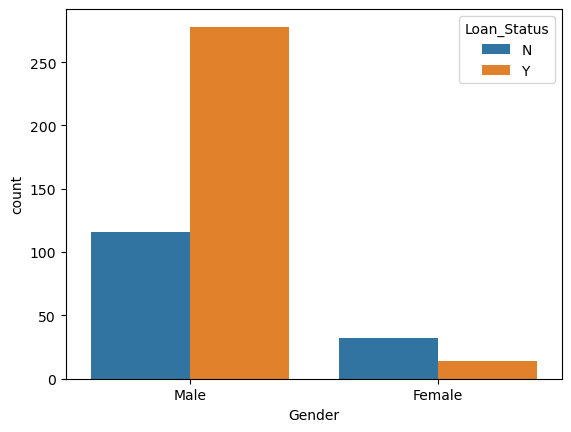

In [27]:
by_race = sns.countplot(x="Gender", hue="Loan_Status", data=df[df.Gender.isin(['Male', 'Female'])])

In [31]:
by_marriage = sns.countplot(x="Married", hue="Loan_Status", data=df['Married'], palette=aq_palette)

ValueError: Could not interpret input 'Married'

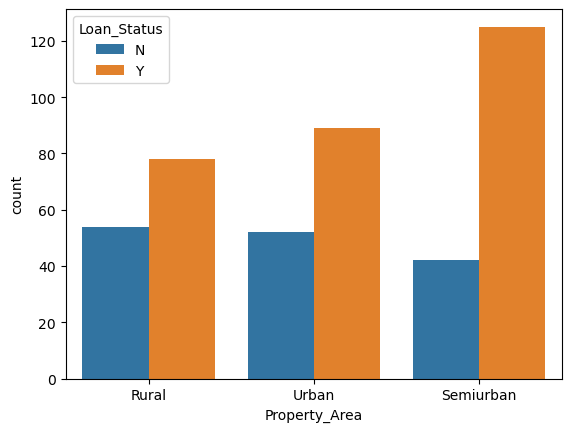

In [32]:
by_property = sns.countplot(x="Property_Area", hue="Loan_Status", data=df)

__Levels of recidivism__

This dataset includes information about whether or not the subject recidivated, and so we can directly test the accuracy of the predictions. First, we visualize the recidivsm rates across race.

Following ProPublica, we defined recidivism as a new arrest within two years. (If a person recidivates, `label_value` = 1). They "based this decision on Northpointe’s practitioners guide, which says that its recidivism score is meant to predict 'a new misdemeanor or felony offense within two years of the COMPAS administration date.'"




/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


AttributeError: 'numpy.int64' object has no attribute 'startswith'

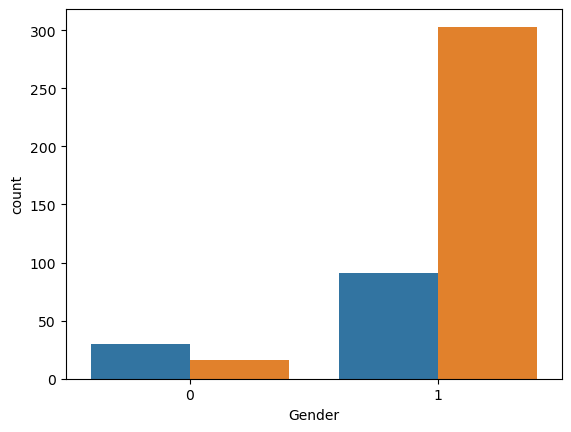

In [33]:
label_by_gender = sns.countplot(x="Gender", hue="Predictions", data=datasetX[datasetX.Gender.isin([1,0])])

/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


AttributeError: 'numpy.int64' object has no attribute 'startswith'

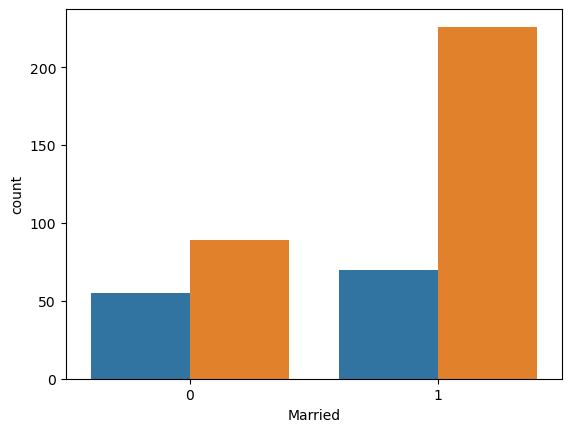

In [ ]:
label_by_marital = sns.countplot(x="Married", hue="Predictions", data=datasetX)

/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


AttributeError: 'numpy.int64' object has no attribute 'startswith'

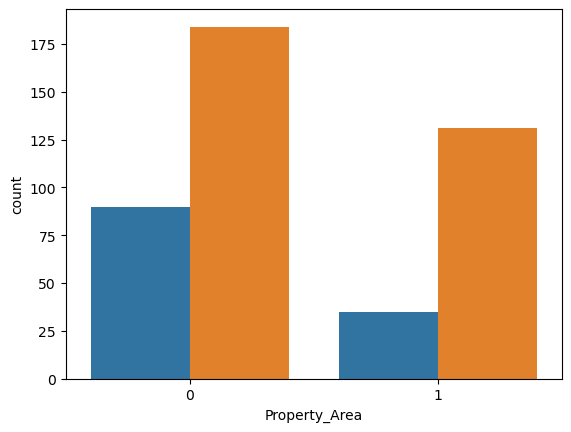

In [ ]:
label_by_sex = sns.countplot(x="Property_Area", hue="Predictions", data=datasetX)

## Putting Aequitas to the task

The graphs above show the base rates for recidivism are higher for black defendants compared to white defendants (.51 vs .39), though the predictions do not match the base rates.

Practitioners face the challenge of determining whether or not such patterns reflect bias or not. The fact that there are multiple ways to measure bias adds complexity to the decision-making process. With Aequitas, we provide a tool that automates the reporting of various fairness metrics to aid in this process.

Applying Aequitas progammatically is a three step process represented by three python classes:

`Group()`: Define groups

`Bias()`: Calculate disparities

`Fairness()`: Assert fairness

Each class builds on the previous one expanding the output DataFrame.


### Data Formatting

Data for this example was preprocessed for compatibility with Aequitas. **The Aequitas tool always requires a `score` column and requires a binary `label_value` column for supervised metrics**, (i.e., False Discovery Rate, False Positive Rate, False Omission Rate, and False Negative Rate).

Preprocessing includes but is not limited to checking for mandatory `score` and `label_value` columns as well as at least one column representing attributes specific to the data set. See [documentation](../input_data.html) for more information about input data.

Note that while `entity_id` is not necessary for this example, Aequitas recognizes `entity_id` as a reserve column name and will not recognize it as an attribute column.

[Back to Top](#top_cell)
<a id='existing_biases'></a>

## What biases exist in my model?

### _Aequitas Group() Class_

<a id='xtab'></a>

### What is the distribution of groups, predicted scores, and labels across my dataset?

Aequitas's `Group()` class enables researchers to evaluate biases across all subgroups in their dataset by assembling a confusion matrix of each subgroup, calculating commonly used metrics such as false positive rate and false omission rate, as well as counts by group and group prevelance among the sample population.

<a id='counts_description'></a>
The **`get_crosstabs()`** method tabulates a confusion matrix for each subgroup and calculates commonly used metrics such as false positive rate and false omission rate. It also provides counts by group and group prevelances.

#### Group Counts Calculated:

| Count Type | Column Name |
| --- | --- |
| False Positive Count | 'fp' |
| False Negative Count | 'fn' |
| True Negative Count | 'tn' |
| True Positive Count | 'tp' |
| Predicted Positive Count | 'pp' |
| Predicted Negative Count | 'pn' |
| Count of Negative Labels in Group | 'group_label_neg' |
| Count of Positive Labels in Group | 'group_label_pos' |
| Group Size | 'group_size'|
| Total Entities | 'total_entities' |

#### Absolute Metrics Calculated:

| Metric | Column Name |
| --- | --- |
| True Positive Rate | 'tpr' |
| True Negative Rate | 'tnr' |
| False Omission Rate | 'for' |
| False Discovery Rate | 'fdr' |
| False Positive Rate | 'fpr' |
| False Negative Rate | 'fnr' |
| Negative Predictive Value | 'npv' |
| Precision | 'precision' |
| Predicted Positive Ratio$_k$ | 'ppr' |
| Predicted Positive Ratio$_g$ | 'pprev' |
| Group Prevalence | 'prev' |


**Note**: The **`get_crosstabs()`** method expects a dataframe with predefined columns `score`, and `label_value` and treats other columns (with a few exceptions) as attributes against which to test for disparities. In this case, we include `race`, `sex` and `age_cat`.

In [34]:
dataset['label_value'] = target
dataset.rename(columns={'Predictions': 'score'}, inplace=True)

dataset

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,score,label_value
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,Y,0
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,Y,1
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,Y,1
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,Y,1
5,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y,Y,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,Male,Yes,0,Graduate,No,3232,1950.0,108.0,360.0,1.0,Rural,Y,Y,1
610,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y,Y,1
611,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y,Y,1
612,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y,Y,1


In [35]:

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 440 entries, 1 to 613
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             440 non-null    object 
 1   Married            440 non-null    object 
 2   Dependents         440 non-null    object 
 3   Education          440 non-null    object 
 4   Self_Employed      440 non-null    object 
 5   ApplicantIncome    440 non-null    int64  
 6   CoapplicantIncome  440 non-null    float64
 7   LoanAmount         440 non-null    float64
 8   Loan_Amount_Term   440 non-null    float64
 9   Credit_History     440 non-null    float64
 10  Property_Area      440 non-null    object 
 11  Loan_Status        440 non-null    object 
 12  score              440 non-null    object 
 13  label_value        440 non-null    int64  
dtypes: float64(4), int64(2), object(8)
memory usage: 51.6+ KB


In [39]:
numerical = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History']
datasetX = dataset.drop(columns=numerical)
datasetX['score'].replace({'N':0,'Y':1}, inplace=True)   
datasetX.drop(columns=['Loan_Status'],inplace=True)
datasetX

/var/folders/xc/73h9x30561961rsyzf84xbvm0000gn/T/ipykernel_23962/1432444547.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  datasetX['score'].replace({'N':0,'Y':1}, inplace=True)
/var/folders/xc/73h9x30561961rsyzf84xbvm0000gn/T/ipykernel_23962/1432444547.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting'

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,score,label_value
1,Male,Yes,1,Graduate,No,Rural,1,0
2,Male,Yes,0,Graduate,Yes,Urban,1,1
3,Male,Yes,0,Not Graduate,No,Urban,1,1
4,Male,No,0,Graduate,No,Urban,1,1
5,Male,Yes,2,Graduate,Yes,Urban,1,1
...,...,...,...,...,...,...,...,...
608,Male,Yes,0,Graduate,No,Rural,1,1
610,Male,Yes,3+,Graduate,No,Rural,1,1
611,Male,Yes,1,Graduate,No,Urban,1,1
612,Male,Yes,2,Graduate,No,Urban,1,1


In [40]:
audit = Audit(datasetX, label_column="label_value")
audit.audit()

[Back to Top](#top_cell)
<a id='xtab_metrics'></a>

### What are bias metrics across groups?

Once you have run the `Group()` class **`get_crosstabs()`** method, you'll have a dataframe of the [group counts](#counts_description) and [group value bias metrics](#counts_description).

The `Group()` class has a **`list_absolute_metrics()`** method, which you can use for faster slicing to view just  counts or bias metrics.

#### View calculated counts across sample population groups

In [41]:
audit.confusion_matrix

pp  pn  fp  fn  tn   tp  group_label_pos  \
attribute_name attribute_value                                              
Gender         Female            16  30   2   0  30   14               14   
               Male             303  91  26   1  90  277              278   
Married        No                88  53  11   0  53   77               77   
               Yes              231  68  17   1  67  214              215   
Dependents     0                176  68  19   0  68  157              157   
               1                 48  24   4   0  24   44               44   
               2                 67  17   4   1  16   63               64   
               3+                28  12   1   0  12   27               27   
Education      Graduate         261  88  24   0  88  237              237   
               Not Graduate      58  33   4   1  32   54               55   
Self_Employed  No               282  98  28   1  97  254              255   
               Yes               37  23   0   0  23   37               37   
Property_Area  Rural             89  43  11   0  43   78               78   
               Semiurban        129  38   5   1  37  124              125   
               Urban            101  40  12   0  40   89               89   

                                group_label_neg  group_size  total_entities  
attribute_name attribute_value                                               
Gender         Female                        32          46             440  
               Male                         116         394             440  
Married        No                            64         141             440  
               Yes                           84         299             440  
Dependents     0                             87         244             440  
               1                             28          72             440  
               2                             20          84             440  
               3+                            13          40             440  
Education      Graduate                     112         349             440  
               Not Graduate                  36          91             440  
Self_Employed  No                           125         380             440  
               Yes                           23          60             440  
Property_Area  Rural                         54         132             440  
               Semiurban                     42         167             440  
               Urban                         52         141             440

#### View calculated absolute metrics for each sample population group

In [42]:
audit.metrics.round(2)

accuracy   tpr   tnr   for   fdr   fpr   fnr  \
attribute_name attribute_value                                                 
Gender         Female               0.96  1.00  0.94  0.00  0.12  0.06  0.00   
               Male                 0.93  1.00  0.78  0.01  0.09  0.22  0.00   
Married        No                   0.92  1.00  0.83  0.00  0.12  0.17  0.00   
               Yes                  0.94  1.00  0.80  0.01  0.07  0.20  0.00   
Dependents     0                    0.92  1.00  0.78  0.00  0.11  0.22  0.00   
               1                    0.94  1.00  0.86  0.00  0.08  0.14  0.00   
               2                    0.94  0.98  0.80  0.06  0.06  0.20  0.02   
               3+                   0.98  1.00  0.92  0.00  0.04  0.08  0.00   
Education      Graduate             0.93  1.00  0.79  0.00  0.09  0.21  0.00   
               Not Graduate         0.95  0.98  0.89  0.03  0.07  0.11  0.02   
Self_Employed  No                   0.92  1.00  0.78  0.01  0.10  0.22  0.00   
               Yes                  1.00  1.00  1.00  0.00  0.00  0.00  0.00   
Property_Area  Rural                0.92  1.00  0.80  0.00  0.12  0.20  0.00   
               Semiurban            0.96  0.99  0.88  0.03  0.04  0.12  0.01   
               Urban                0.91  1.00  0.77  0.00  0.12  0.23  0.00   

                                 npv  precision   ppr  pprev  prev  
attribute_name attribute_value                                      
Gender         Female           1.00       0.88  0.05   0.35  0.30  
               Male             0.99       0.91  0.95   0.77  0.71  
Married        No               1.00       0.88  0.28   0.62  0.55  
               Yes              0.99       0.93  0.72   0.77  0.72  
Dependents     0                1.00       0.89  0.55   0.72  0.64  
               1                1.00       0.92  0.15   0.67  0.61  
               2                0.94       0.94  0.21   0.80  0.76  
               3+               1.00       0.96  0.09   0.70  0.68  
Education      Graduate         1.00       0.91  0.82   0.75  0.68  
               Not Graduate     0.97       0.93  0.18   0.64  0.60  
Self_Employed  No               0.99       0.90  0.88   0.74  0.67  
               Yes              1.00       1.00  0.12   0.62  0.62  
Property_Area  Rural            1.00       0.88  0.28   0.67  0.59  
               Semiurban        0.97       0.96  0.40   0.77  0.75  
               Urban            1.00       0.88  0.32   0.72  0.63

[Back to Top](#top_cell)
<a id='interpret_bias'></a>

### How do I interpret biases in my model?
In the slice of the crosstab dataframe created by the `Group()` class **`get_crosstabs()`** method directly above, we see that African-Americans have a false positive rate (`fpr`) of 45%, while Caucasians have a false positive rate of only 23%. This means that African-American people are far more likely to be falsely labeled as high-risk than white people. On the other hand, false ommision rates (`for`) and false discovery rates (`fdr`) are much closer for those two groups.

[Back to Top](#top_cell)
<a id='disparities'></a>

## What levels of disparity exist between population groups?

### _Aequitas Bias() Class_
We use the Aequitas `Bias()` class to calculate disparities between groups based on the crosstab returned by the `Group()` class **`get_crosstabs()`** method described above. Disparities are calculated as a ratio of a metric for a group of interest compared to a base group. For example, the False Negative Rate Disparity for black defendants vis-a-vis whites is:
$$Disparity_{FNR} =  \frac{FNR_{black}}{FNR_{white}}$$

Below, we use **`get_disparity_predefined_groups()`** which allows us to choose reference groups that clarify the output for the practitioner.

The Aequitas `Bias()` class includes two additional get disparity functions: **`get_disparity_major_group()`** and **`get_disparity_min_metric()`**, which automate base group selection based on sample majority (across each attribute) and minimum value for each calculated bias metric, respectively.  

The **`get_disparity_predefined_groups()`** allows user to define a base group for each attribute, as illustrated below.

#### Disparities Calculated Calcuated:

| Metric | Column Name |
| --- | --- |
| True Positive Rate Disparity | 'tpr_disprity' |
| True Negative Rate | 'tnr_disparity' |
| False Omission Rate | 'for_disparity' |
| False Discovery Rate | 'fdr_disparity' |
| False Positive Rate | 'fpr_disparity' |
| False NegativeRate | 'fnr_disparity' |
| Negative Predictive Value | 'npv_disparity' |
| Precision Disparity | 'precision_disparity' |
| Predicted Positive Ratio$_k$ Disparity | 'ppr_disparity' |
| Predicted Positive Ratio$_g$ Disparity | 'pprev_disparity' |


Columns for each disparity are appended to the crosstab dataframe, along with a column indicating the reference group for each calculated metric (denoted by `[METRIC NAME]_ref_group_value`). We see a slice of the dataframe with calculated metrics in the next section.

#### Disparities calculated in relation to a user-specified group for each attribute

In [43]:
datasetX

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,score,label_value
1,Male,Yes,1,Graduate,No,Rural,1,0
2,Male,Yes,0,Graduate,Yes,Urban,1,1
3,Male,Yes,0,Not Graduate,No,Urban,1,1
4,Male,No,0,Graduate,No,Urban,1,1
5,Male,Yes,2,Graduate,Yes,Urban,1,1
...,...,...,...,...,...,...,...,...
608,Male,Yes,0,Graduate,No,Rural,1,1
610,Male,Yes,3+,Graduate,No,Rural,1,1
611,Male,Yes,1,Graduate,No,Urban,1,1
612,Male,Yes,2,Graduate,No,Urban,1,1


In [44]:
audit = Audit(datasetX.drop(columns=numerical), label_column="label_value",
              reference_groups={'Gender':'Male', 'Married':'Yes','Dependents':'0','Education':'Graduate', 'Self_Employed':'No','Property_Area':'Semiurban'})

audit.audit(bias_args={
    "alpha": 0.05,
    "check_significance": True,
    "mask_significance": True
})

audit.disparity_df.style

KeyError: "['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History'] not found in axis"

In [ ]:
bdf = audit.disparity_df

The `Bias()` class includes a method to quickly return a list of calculated disparities from the dataframe returned by the **`get_disparity_`** methods.

In [ ]:
audit.disparities.style

In [45]:
metrics = ['fpr','fdr']
disparity_tolerance = 1.25

# Aequitas Visualizations

In [46]:
audit.summary_plot(metrics=metrics, fairness_threshold=disparity_tolerance)

/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/aequitas/plot/summary_chart.py:372: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  attribute_df.groupby(by=f"{metric}_parity_result")
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/aequitas/plot/summary_chart.py:372: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  attribute_df.groupby(by=f"{metric}_parity_result")
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/aequitas/plot/summary_chart.py:372: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version o

alt.VConcatChart(...)

### Check for disparities in Gender

In [47]:
audit.disparity_plot(metrics=metrics, attribute='Gender', fairness_threshold=disparity_tolerance)

/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add

/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


alt.LayerChart(...)

#### Check how the fairness threshold maps to the absolute values of each metric


In [48]:
ap.absolute(bdf, metrics, 'Gender', fairness_threshold = disparity_tolerance)

NameError: name 'bdf' is not defined

### Check for disparities in Sex

In [ ]:
ap.disparity(bdf, metrics, 'Married', fairness_threshold = disparity_tolerance)

/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add

alt.LayerChart(...)

#### Check how the fairness threshold maps to the absolute values of each metric


In [ ]:
ap.absolute(bdf, metrics, 'Property_Area', fairness_threshold = disparity_tolerance)

/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add

alt.LayerChart(...)

### Check for disparities in Education, Self_Employed and Dependents

In [ ]:
ap.disparity(bdf, metrics, 'Education', fairness_threshold = disparity_tolerance)

/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add

alt.LayerChart(...)

#### Check how the fairness threshold maps to the absolute values of each metric


In [49]:
ap.absolute(bdf, metrics, 'Dependents', fairness_threshold = disparity_tolerance)

NameError: name 'bdf' is not defined

In [50]:
ap.absolute(bdf, metrics, 'Self_Employed', fairness_threshold = disparity_tolerance)

NameError: name 'bdf' is not defined

[Back to Top](#top_cell)
<a id='interpret_disp'></a>

### How do I interpret calculated disparity ratios?
The calculated disparities from the dataframe returned by the `Bias()` class **`get_disparity_`** methods are in relation to a reference group, which will always have a disparity of 1.0.

The differences in False Positive Rates, noted in the discussion of the `Group()` class above, are clarified using the disparity ratio (`fpr_disparity`). Black people are falsely identified as being high or medium risks 1.9 times the rate for white people.

As seen above, False Discovery Rates have much less disparity (`fdr_disparity`), or fraction of false postives over predicted positive in a group. As reference groups have disparity = 1 by design in Aequitas, the lower disparity is highlighted by the `fdr_disparity` value close to 1.0 (0.906) for the race attribute group 'African-American' when disparities are calculated using predefined base group 'Caucasian'. Note that COMPAS is calibrated to  balance False Positive Rate and False Discovery Rates across groups.

[Back to Top](#top_cell)
<a id='disparity_calc'></a>

### How does the selected reference group affect disparity calculations?

Disparities calculated in the the Aequitas `Bias()` class based on the crosstab returned by the `Group()` class **`get_crosstabs()`** method can be derived using several different base gorups. In addition to using user-specified groups illustrated above, Aequitas can automate base group selection based on dataset characterisitcs:

#### Evaluating disparities calculated in relation to a different 'race' reference group
Changing even one attribute in the predefined groups will alter calculated disparities. When a differnet pre-defined group 'Hispanic' is used, we can see that Black people are 2.1 times more likely to be falsely identified as being high or medium risks as Hispanic people are (compared to 1.9 times more likely than white people), and even less likely to be falsely identified as low risk when compared to Hispanic people rather than white people.

In [51]:
from aequitas.group import Group
from aequitas.bias import Bias
b = Bias()
g = Group()
xx = datasetX
xtab, _ = g.get_crosstabs(xx)
xx
x_copy = xx.copy()

In [52]:
xtab

,model_id,score_threshold,k,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,...,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,0,binary 0/1,319,Gender,Female,0.956522,1.000000,0.937500,0.000000,0.125000,...,0.347826,2,0,30,14,14,32,46,440,0.304348
1,0,binary 0/1,319,Gender,Male,0.931472,0.996403,0.775862,0.010989,0.085809,...,0.769036,26,1,90,277,278,116,394,440,0.705584
2,0,binary 0/1,319,Married,No,0.921986,1.000000,0.828125,0.000000,0.125000,...,0.624113,11,0,53,77,77,64,141,440,0.546099
3,0,binary 0/1,319,Married,Yes,0.939799,0.995349,0.797619,0.014706,0.073593,...,0.772575,17,1,67,214,215,84,299,440,0.719064
4,0,binary 0/1,319,Dependents,0,0.922131,1.000000,0.781609,0.000000,0.107955,...,0.721311,19,0,68,157,157,87,244,440,0.643443
5,0,binary 0/1,319,Dependents,1,0.944444,1.000000,0.857143,0.000000,0.083333,...,0.666667,4,0,24,44,44,28,72,440,0.611111
6,0,binary 0/1,319,Dependents,2,0.940476,0.984375,0.800000,0.058824,0.059701,...,0.797619,4,1,16,63,64,20,84,440,0.761905
7,0,binary 0/1,319,Dependents,3+,0.975000,1.000000,0.923077,0.000000,0.035714,...,0.700000,1,0,12,27,27,13,40,440,0.675000
8,0,binary 0/1,319,Education,Graduate,0.931232,1.000000,0.785714,0.000000,0.091954,...,0.747851,24,0,88,237,237,112,349,440,0.679083
9,0,binary 0/1,319,Education,Not Graduate,0.945055,0.981818,0.888889,0.030303,0.068966,...,0.637363,4,1,32,54,55,36,91,440,0.604396


In [53]:
hbdf = b.get_disparity_predefined_groups(xtab, original_df=xx,
                                         ref_groups_dict={'Gender':'Male', 'Married':'Yes','Dependents':'0','Education':'Graduate', 'Self_Employed':'No','Property_Area':'Semiurban'},
                                         alpha=0.05,
                                         check_significance=True,
                                         mask_significance=False,
                                         selected_significance=['fpr', 'for', 'fdr'])


/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/scipy/stats/_morestats.py:2710: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/scipy/stats/_morestats.py:2573: RuntimeWarning: divide by zero encountered in log
  numer = (Ntot*1.0 - k) * log(spsq) - np.sum((Ni - 1.0)*log(ssq), axis=0)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/scipy/stats/_morestats.py:2573: RuntimeWarning: invalid value encountered in double_scalars
  numer = (Ntot*1.0 - k) * log(spsq) - np.sum((Ni - 1.0)*log(ssq), axis=0)


In [54]:
# View disparity metrics added to dataframe
hbdf[['attribute_name', 'attribute_value'] +
     b.list_disparities(hbdf) + b.list_significance(hbdf)]

,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,tnr_disparity,tpr_disparity,label_value_significance,score_significance,fdr_significance,for_significance,fpr_significance
0,Gender,Female,1.456731,0.0,0.0,0.278846,1.011111,0.052805,0.452289,0.957130,1.208333,1.003610,3.198700e-08,6.879297e-10,5.906190e-01,0.568024,5.906190e-01
1,Gender,Male,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00
2,Married,No,1.698529,0.0,0.0,0.849265,1.014925,0.380952,0.807835,0.944509,1.038246,1.004673,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00
3,Married,Yes,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.084689e-01,6.575438e-02,6.094340e-08,0.630053,6.094340e-08
4,Dependents,0,1.000000,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,NaN,1.000000e+00
5,Dependents,1,0.771930,NaN,NaN,0.654135,1.000000,0.272727,0.924242,1.027601,1.096639,1.000000,6.176620e-01,3.713765e-01,6.202564e-01,NaN,6.202564e-01
6,Dependents,2,0.553024,10.0,10.0,0.915789,0.941176,0.380682,1.105790,1.054093,1.023529,0.984375,3.576247e-02,1.696307e-01,2.526609e-01,0.332195,2.526609e-01
7,Dependents,3+,0.330827,NaN,NaN,0.352227,1.000000,0.159091,0.970455,1.080983,1.180995,1.000000,6.997424e-01,7.821385e-01,2.345384e-01,NaN,2.345384e-01
8,Education,Graduate,1.000000,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,NaN,1.000000e+00
9,Education,Not Graduate,0.750000,10.0,10.0,0.518519,0.969697,0.222222,0.852259,1.025316,1.131313,0.981818,1.800555e-01,4.966697e-02,5.771259e-01,0.102702,5.771259e-01


#### Disparities calculated in relation to sample population majority group (in terms of group prevalence) for each attribute
The majority population groups for each attribute ('race', 'sex', 'age_cat') in the COMPAS dataset are 'African American', 'Male', and '25 - 45'. Using the **`get_disparity_major_group()`** method of calculation allows researchers to quickly evaluate how much more (or less often) other groups are falsely or correctly identified as high- or medium-risk in relation to the group they have the most data on.

In [55]:
majority_bdf = b.get_disparity_major_group(xtab, original_df=xx)

In [56]:
majority_bdf[['attribute_name', 'attribute_value'] +  b.list_disparities(majority_bdf)]

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,Gender,Female,0.052805,0.452289,0.957130,1.456731,0.0,0.278846,0.0,1.003610,1.208333,1.011111
1,Gender,Male,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000
2,Married,No,0.380952,0.807835,0.944509,1.698529,0.0,0.849265,0.0,1.004673,1.038246,1.014925
3,Married,Yes,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000
4,Dependents,0,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,NaN,1.000000,1.000000,1.000000
5,Dependents,1,0.272727,0.924242,1.027601,0.771930,NaN,0.654135,NaN,1.000000,1.096639,1.000000
6,Dependents,2,0.380682,1.105790,1.054093,0.553024,10.0,0.915789,10.0,0.984375,1.023529,0.941176
7,Dependents,3+,0.159091,0.970455,1.080983,0.330827,NaN,0.352227,NaN,1.000000,1.180995,1.000000
8,Education,Graduate,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,NaN,1.000000,1.000000,1.000000
9,Education,Not Graduate,0.222222,0.852259,1.025316,0.750000,10.0,0.518519,10.0,0.981818,1.131313,0.969697


#### Disparities calculated in relation to the minimum value for each metric

When you do not have a pre-existing don’t frame of reference or policy context for the dataset (ex: Caucasians or males historically favored), you may choose to view disparities in relation to the group with the lowest value for every disparity metric, as then every group's value will be at least 1.0, and relationships can be evaluated more linearly.


Note that disparities are much more varied, and may have larger magnitude, when the minimum value per metric is used as a reference group versus one of the other two methods.

In [57]:
min_metric_bdf = b.get_disparity_min_metric(df=xtab, original_df=xx,
                                            check_significance=True)
min_metric_bdf.style

/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/scipy/stats/_morestats.py:2710: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/scipy/stats/_morestats.py:2573: RuntimeWarning: divide by zero encountered in log
  numer = (Ntot*1.0 - k) * log(spsq) - np.sum((Ni - 1.0)*log(ssq), axis=0)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/scipy/stats/_morestats.py:2573: RuntimeWarning: invalid value encountered in double_scalars
  numer = (Ntot*1.0 - k) * log(spsq) - np.sum((Ni - 1.0)*log(ssq), axis=0)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/scipy/stats/_morestats.py:2710: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/scipy/stats/_morestats.py:2573: RuntimeWarning: divide by zero encountered in log
  numer = (Ntot*1.0 - k) * log

,model_id,score_threshold,k,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,label_value_significance,score_significance,fdr_disparity,fdr_ref_group_value,fdr_significance,fnr_disparity,fnr_ref_group_value,fnr_significance,for_disparity,for_ref_group_value,for_significance,fpr_disparity,fpr_ref_group_value,fpr_significance,npv_disparity,npv_ref_group_value,npv_significance,ppr_disparity,ppr_ref_group_value,ppr_significance,pprev_disparity,pprev_ref_group_value,pprev_significance,precision_disparity,precision_ref_group_value,precision_significance,tnr_disparity,tnr_ref_group_value,tnr_significance,tpr_disparity,tpr_ref_group_value,tpr_significance
0,0,binary 0/1,319,Gender,Female,0.956522,1.000000,0.937500,0.000000,0.125000,0.062500,0.000000,1.000000,0.875000,16,30,0.050157,0.347826,2,0,30,14,14,32,46,440,0.304348,False,False,1.456731,Male,False,nan,Female,None,nan,Female,None,1.000000,Female,False,1.011111,Male,False,1.000000,Female,False,1.000000,Female,False,1.000000,Female,False,1.208333,Male,False,1.003610,Male,False
1,0,binary 0/1,319,Gender,Male,0.931472,0.996403,0.775862,0.010989,0.085809,0.224138,0.003597,0.989011,0.914191,303,91,0.949843,0.769036,26,1,90,277,278,116,394,440,0.705584,True,True,1.000000,Male,False,10.000000,Female,False,10.000000,Female,False,3.586207,Female,False,1.000000,Male,False,18.937500,Female,True,2.210977,Female,True,1.044790,Female,False,1.000000,Male,False,1.000000,Male,False
2,0,binary 0/1,319,Married,No,0.921986,1.000000,0.828125,0.000000,0.125000,0.171875,0.000000,1.000000,0.875000,88,53,0.275862,0.624113,11,0,53,77,77,64,141,440,0.546099,False,False,1.698529,Yes,True,nan,No,False,nan,No,False,1.000000,No,True,1.014925,Yes,False,1.000000,No,False,1.000000,No,False,1.000000,No,False,1.038246,Yes,False,1.004673,Yes,False
3,0,binary 0/1,319,Married,Yes,0.939799,0.995349,0.797619,0.014706,0.073593,0.202381,0.004651,0.985294,0.926407,231,68,0.724138,0.772575,17,1,67,214,215,84,299,440,0.719064,False,False,1.000000,Yes,None,10.000000,No,None,10.000000,No,None,1.177489,No,None,1.000000,Yes,False,2.625000,No,False,1.237876,No,False,1.058751,No,True,1.000000,Yes,True,1.000000,Yes,False
4,0,binary 0/1,319,Dependents,0,0.922131,1.000000,0.781609,0.000000,0.107955,0.218391,0.000000,1.000000,0.892045,176,68,0.551724,0.721311,19,0,68,157,157,87,244,440,0.643443,False,False,3.022727,3+,False,nan,0,None,nan,0,None,2.839080,3+,False,1.062500,2,False,6.285714,3+,False,1.081967,1,False,1.000000,0,False,1.000000,0,False,1.015873,2,False
5,0,binary 0/1,319,Dependents,1,0.944444,1.000000,0.857143,0.000000,0.083333,0.142857,0.000000,1.000000,0.916667,48,24,0.150470,0.666667,4,0,24,44,44,28,72,440,0.611111,False,False,2.333333,3+,False,nan,0,None,nan,0,None,1.857143,3+,False,1.062500,2,False,1.714286,3+,False,1.000000,1,False,1.027601,0,False,1.096639,0,False,1.015873,2,False
6,0,binary 0/1,319,Dependents,2,0.940476,0.984375,0.800000,0.058824,0.059701,0.200000,0.015625,0.941176,0.940299,67,17,0.210031,0.797619,4,1,16,63,64,20,84,440,0.761905,False,False,1.671642,3+,False,10.000000,0,False,10.000000,0,False,2.600000,3+,False,1.000000,2,False,2.392857,3+,False,1.196429,1,False,1.054093,0,False,1.023529,0,False,1.000000,2,False
7,0,binary 0/1,319,Dependents,3+,0.975000,1.000000,0.923077,0.000000,0.035714,0.076923,0.000000,1.000000,0.964286,28,12,0.087774,0.700000,1,0,12,27,27,13,40,440,0.675000,False,False,1.000000,3+,False,nan,0,None,nan,0,None,1.000000,3+,False,1.062500,2,False,1.000000,3+,False,1.050000,1,False,1.080983,0,False,1.180995,0,False,1.015873,2,False
8,0,binary 0/1,319,Education,Graduate,0.931232,1.000000,0.785714,0.000000,0.091954,0.214286,0.000000,1.000000,0.908046,261,88,0.818182,0.747851,24,0,88,237,237,112,349,440,0.679083,False,True,1.333333,Not Graduate,False,nan,Graduate,None,nan,Graduate,None,1.928571,Not Graduate,False,1.031250,Not Graduate,False,4.500000,Not Graduate,True,1

[Back to Top](#top_cell)
<a id='disparity_viz'></a>

## How do I visualize disparities in my model?
To visualize disparities in the dataframe returned by one of the `Bias()` class **`get_disparity_`** methods use one of two methods in the Aequitas `Plot()` class:

A particular disparity metric can be specified with **`plot_disparity()`**. To plot a single disparity, a metric and an attribute must be specified.

Disparities related to a list of particular metrics of interest or `'all'` metrics can be plotted with **`plot_disparity_all()`**.  At least one metric or at least one attribute must be specified when plotting multiple disparities (or the same disparity across multiple attributes). For example, to plot PPR and and Precision disparity for all attributes, specify `metrics=['ppr', 'precision']` with no attribute specified, and to plot default metrics by race, specify `attributes=['race']` and with no metrics specified.

**Reference groups are displayed in grey, and always have a disparity = 1.** Note that disparities greater than 10x reference group will are visualized as 10x, and disparities less than 0.1x reference group are visualized as 0.1x.

Statistical siginificance (at a default value of 0.05) is denoted by two asterisks (**) next to a treemap square's value.

In [ ]:
f = Fairness()
fdf = f.get_group_value_fairness(bdf)

The `Fairness()` class includes a method to quickly return a list of fairness determinations from the dataframe returned by the **`get_group_value_fairness()`** method.

In [ ]:
parity_detrminations = f.list_parities(fdf)


In [ ]:
absolute_metrics= g.absolute_metrics(df=x_copy)


TypeError: 'tuple' object is not callable

In [ ]:
fdf[['attribute_name', 'attribute_value'] + b.list_disparities(fdf) + parity_detrminations].style

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,NPV Parity,FOR Parity,TypeI Parity,FNR Parity,FDR Parity,FPR Parity,Supervised Fairness,Statistical Parity,TNR Parity,Unsupervised Fairness,TPR Parity,Impact Parity,TypeII Parity,Precision Parity,Equalized Odds
0,Gender,Female,0.055921,0.478976,0.900550,2.063348,nan,0.418269,nan,1.000000,1.168056,1.000000,True,nan,False,nan,False,False,False,False,True,False,True,False,nan,True,False
1,Gender,Male,1.000000,1.000000,1.000000,1.000000,nan,1.000000,nan,1.000000,1.000000,1.000000,True,nan,True,nan,True,True,False,True,True,True,True,True,nan,True,True
2,Married,No,0.377682,0.809319,0.931608,1.868984,nan,0.926471,nan,1.000000,1.018657,1.000000,True,nan,False,nan,False,True,False,False,True,False,True,True,nan,True,True
3,Married,Yes,1.000000,1.000000,1.000000,1.000000,nan,1.000000,nan,1.000000,1.000000,1.000000,True,nan,True,nan,True,True,False,True,True,True,True,True,nan,True,True
4,Dependents,0,1.000000,1.000000,1.000000,1.000000,nan,1.000000,nan,1.000000,1.000000,1.000000,True,nan,True,nan,True,True,False,True,True,True,True,True,nan,True,True
5,Dependents,1,0.287356,0.939733,1.032774,0.732632,nan,0.654135,nan,1.000000,1.096639,1.000000,True,nan,False,nan,False,False,False,False,True,False,True,True,nan,True,False
6,Dependents,2,0.390805,1.139454,1.040038,0.673375,nan,1.144737,nan,1.000000,0.959559,1.000000,True,nan,False,nan,False,True,False,False,True,False,True,True,nan,True,True
7,Dependents,3+,0.166667,0.983740,1.083871,0.315789,nan,0.352227,nan,1.000000,1.180995,1.000000,True,nan,False,nan,False,False,False,False,True,False,True,True,nan,True,False
8,Education,Graduate,1.000000,1.000000,1.000000,1.000000,nan,1.000000,nan,1.000000,1.000000,1.000000,True,nan,True,nan,True,True,False,True,True,True,True,True,nan,True,True
9,Education,Not Graduate,0.229885,0.881647,1.009494,0.906250,nan,0.648148,nan,1.000000,1.095960,1.000000,True,nan,False,nan,True,False,False,False,True,False,True,True,nan,True,False


[Back to Top](#top_cell)
<a id='interpret_fairness'></a>

### How do I interpret parities?
Calling the Aequitas `Fairness()` class **`get_group_value_fairness()`** method on the dataframe returned from a `Bias()` class `get_dispariy` method will return the dataframe with additional columns indicating parities, as seen in the slice of the `get_group_value_fairness` data frame directly above.

In this case, our base groups are Caucasian for race, Male for gender, and 25-45 for age_cat. By construction, the base group has supervised fairness. (The disparity ratio is 1). Relative to the base groups, the COMPAS predictions only provide supervised fairness to one group, Hispanic.

Above, the African-American false omission and false discovery are within the bounds of fairness. This result is expected because COMPAS is calibrated. (Given calibration, it is surprising that Asian and Native American rates are so low. This may be a matter of having few observations for these groups.)

On the other hand, African-Americans are roughly twice as likely to have false positives and 40 percent less likely to false negatives. In real terms, 44.8% of African-Americans who did not recidivate were marked high or medium risk (with potential for associated penalties), compared with 23.4% of Caucasian non-reoffenders. This is unfair and is marked False below.

These findings mark an inherent trade-off between FPR Fairness, FNR Fairness and calibration, which is present in any decision system where base rates are not equal. See [Chouldechova (2017)](https://www.andrew.cmu.edu/user/achoulde/files/disparate_impact.pdf). Aequitas helps bring this trade-off to the forefront with clear metrics and asks system designers to make a reasoned decision based on their use case.

### Attribute Level Fairness
Use the **`get_group_attribute_fairness()`** function to view only the calculated parities from the **`get_group_value_fairness()`** function at the attribute level.

In [ ]:
gaf = f.get_group_attribute_fairness(fdf)
gaf

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,Dependents,False,True,False,False,NaN,NaN,True,True,True,True,False,NaN,False,False,False
1,0,binary 0/1,Education,False,True,True,False,NaN,NaN,True,True,True,True,False,NaN,False,False,False
2,0,binary 0/1,Gender,False,False,False,False,NaN,NaN,True,True,True,True,False,NaN,False,False,False
3,0,binary 0/1,Loan_Status,False,False,False,NaN,NaN,NaN,True,NaN,NaN,False,False,NaN,False,False,False
4,0,binary 0/1,Married,False,True,False,True,NaN,NaN,True,True,True,True,False,NaN,True,False,False
5,0,binary 0/1,Property_Area,False,True,False,False,NaN,NaN,True,True,True,True,False,NaN,False,False,False
6,0,binary 0/1,Self_Employed,False,True,False,False,NaN,NaN,True,False,True,True,False,NaN,False,False,False


### Overall Fairness
The **`get_overall_fairness()`** function gives a quick boolean assessment of the output of **`get_group_value_fairness()`** or **`get_group_attribute_fairness()`**, returning a dictionary with a determination across all attributes for each of:
- Unsupervised Fairness
- Supervised Fairness
- Overall Fairness

In [ ]:
gof = f.get_overall_fairness(fdf)
gof

{'Unsupervised Fairness': False,
 'Supervised Fairness': False,
 'Overall Fairness': False}

## The Aequitas Effect

By breaking down the COMPAS predictions using a variety of bias and disparity metrics calculated using different reference groups, we are able to surface the specific metrics for which the model is imposing bias on given attribute groups, and have a clearer lens when evaluating models and making recommendations for intervention.

Researchers utilizing Aequitas will be able to make similar evaluations on their own data sets, and as they continue to use the tool, will begin to identify patterns in where biases exist and which models appear to produce less bias, thereby helping to reduce bias and its effects in future algorithm-based decision-making.

[Back to Top](#top_cell)